Video Link: https://drive.google.com/drive/folders/1-6m5FkLuVzQiVCfpbAxVRgA53CwoPuJI

Not all the functions created were used in the project, some were created to discover some thresholds to get a general idea of how the values looks like, some were created to fix or detect some problems that we found alternaive solutions to them

The explanation of the functions will be written as comments above and within the function

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import math
from scipy.fftpack import fft2, fftshift
from collections import Counter
from scipy.signal import find_peaks



def crop_image_contour_sorry_kiwi(img_gray): 

    #For contour detection we need to binarize the image so thresholding
    #Close for better results
    #Get all the contours of the image and find the largest one 

    #Use boudningRect to find barcode shaped contour
    #get the coordinated of the corners
    #Shift it the contour one pixel as after trial it turned out to need that
    
    if img_gray.dtype != np.uint8:
        img_gray = cv2.convertScaleAbs(img_gray)

    _, binary_img = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # draw the bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)
    contour_img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)  
    cv2.rectangle(contour_img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # adjust the bounding box to shift left and right
    shifted_x = x - 1  
    shifted_w = w + 1  

    shifted_x = max(0, shifted_x)  # make sure that x doesn't go below 0
    shifted_w = min(img_gray.shape[1] - shifted_x, shifted_w)  # ensure the width doesn't exceed the image width

    cropped_barcode = img_gray[y:y+h, shifted_x:shifted_x+shifted_w]

    # this is to remove edges that may be distorted around the corners, so we can eliminate any change in intensities that are
    # vertical to make sure that at the end we can filter the horizonal ones only
    bottom_pixels=10 
    top_pixels=10

    # new dimensions
    height, width = cropped_barcode.shape[:2]
    cropped_image = cropped_barcode[top_pixels:height-bottom_pixels, :]
    
    return cropped_image

  
def threshold_image(image,threshold_value,max_value):
    #every pixel that has value greater than or equal threshold_value, will be set to max_value, otherwise the pixel will be zero (black)
    _, thresholded_image = cv2.threshold(image, threshold_value, max_value, cv2.THRESH_BINARY)
    return thresholded_image

def sobel_edge_detection(image):
    # add 3 pixels of white padding around the image, we added the padding because sometimes we used this function when the image was cropped
    padded_image = cv2.copyMakeBorder(image, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=255)
    
    sobel_x = cv2.Sobel(padded_image, cv2.CV_64F, 1, 0, ksize=3)  
    sobel_y = cv2.Sobel(padded_image, cv2.CV_64F, 0, 1, ksize=3) 
    edges = cv2.magnitude(sobel_x, sobel_y)
    edges = cv2.convertScaleAbs(edges)
    
    # remove the padding from the edge-detected image
    final_edges = edges[3:-3, 3:-3]
    
    return final_edges



# 3lshan nengez
def display_image(img,title=''):
        plt.figure(figsize=(8, 6))  
        plt.imshow(img,cmap='gray')
        plt.axis('off') 
        plt.title(title)
        plt.show()

# 3lshan nengez bardo
def show_frequency_domain(image,title=''):

    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  
   
    magnitude = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    magnitude_spectrum = 20 * np.log1p(magnitude)  # Log scale for better visibility


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray')
    plt.title('Original Image '+title), plt.axis('off')
    plt.subplot(1, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Frequency Domain '+title), plt.axis('off')
    plt.show()


def find_threshold_value(img_gray):
    hist_counts, bin_edges = np.histogram(img_gray.ravel(), bins=64, range=(0, 256))
    total_pixels = img_gray.size
    
    # Calculate the number of pixels in the dark region (0 to 127)
    dark_pixels = np.sum(hist_counts[:32])  

    # Calculate the number of pixels in the bright region (128 to 255)
    bright_pixels = np.sum(hist_counts[32:])  

    # get the percentage of dark and bright pixels
    dark_percentage = dark_pixels / total_pixels
    bright_percentage = bright_pixels / total_pixels

    # Get indices of the top 5 bins with the highest counts, excluding zero bins
    non_zero_indices = np.where(hist_counts > 0)[0] 
    top_5_indices = np.argsort(hist_counts[non_zero_indices])[-5:][::-1]  
    top_5_bins = [bin_edges[non_zero_indices[i]] for i in top_5_indices]
    # print(top_5_bins)

    # tried weighted average first but this is better apparently and kinda makes sense
    top_5_values = [np.mean([bin_edges[non_zero_indices[i]], bin_edges[non_zero_indices[i] + 1]]) for i in top_5_indices]

 
    average = np.mean(top_5_values)

    contrast_bin_range = (120, 136)  
    contrast_bins = np.sum(hist_counts[np.logical_and(bin_edges[:-1] >= contrast_bin_range[0], bin_edges[:-1] < contrast_bin_range[1])])
    contrast_percentage = contrast_bins / total_pixels


    #The values for the every one 

    if contrast_percentage > 0.6:  # threshold for contrast concentration
        return math.floor(average)

    if dark_percentage > 0.8:
         return math.floor(average)  # threshold for dark-biased images
    elif bright_percentage > 0.95:  #makes sense that this threshold needs to be higher than dark since the picture by default would be biased to white (background)
      
         return math.floor(average)  # threshold for bright-biased images
    else:
         return math.floor(average)

    


# this function will be used in the next function, its created to
# avoid having a strict bandwidth cutoff that would introduce sharp edges in the frequency domain, leading to ringing
def create_smooth_mask(rows, cols, crow, ccol, bandwidth, horizontal, vertical):
    mask = np.zeros((rows, cols, 2), np.float32)
    for i in range(rows):
        for j in range(cols):
            # gaussian falloff for the horizontal band
            if horizontal and abs(i - crow) < bandwidth:
                mask[i, j, :] = np.exp(-((i - crow) ** 2) / (2 * bandwidth ** 2))
            # gaussian falloff for the vertical band
            if vertical and abs(j - ccol) < bandwidth:
                mask[i, j, :] = np.exp(-((j - ccol) ** 2) / (2 * bandwidth ** 2))
    return mask



# this function is  created to create a mask in the frequency domain and with a very strict bandwidth of 1
# remove any sinc not centered in the middle and horizonatal
# we are using the assumption that the perfect image should only have sinc in the middle that is horizontal, no change in intensities vertically
# we remove any noise (objects for example got removed, also salt and peper got removed)

def mask_freq(image,horizontal,vertical):
    # fourier transform
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # shift zero frequency to the center

    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

    # Create a mask to retain horizontal and vertical frequencies
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Center of the frequency domain



    bandwidth = 1  # Adjust this based on desired frequency range
    mask = create_smooth_mask(rows, cols, crow, ccol, bandwidth, horizontal, vertical)

    # Apply the mask to the frequency domain
    filtered_dft = dft_shift * mask

    # Shift back and inverse Fourier Transform to return to the spatial domain
    filtered_dft_shift = np.fft.ifftshift(filtered_dft)
    filtered_image = cv2.idft(filtered_dft_shift)
    filtered_image = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

    # Normalize the filtered image for better visualization
    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX)

    filtered_image=threshold_image(filtered_image,100,255)
    
    return filtered_image


# this function was used after removing the object, to connect the lines by hough transform, then apply region filling and invert the pix
# but we discovered later that this could be achieved by closing with kernel the same length of the bar, or by using or mask_freq function removes all the noise
def houghTransform(image):
    edge_detection=sobel_edge_detection(image)

    lines = cv2.HoughLinesP(edge_detection, 1, np.pi / 180, threshold=80, minLineLength=30, maxLineGap=200) #hyperparametrs trial and error 

    final_image = edge_detection.copy()

    # Draw the lines on the thresholded_edges image with thinner lines
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Calculate the angle of the line
            angle = np.arctan2(y2 - y1, x2 - x1)
            # remove horizontal lines by checking if the angle is near 0 or π
            if abs(angle) > np.pi / 6:  # avoid nearly horizontal lines
                cv2.line(final_image, (x1, y1), (x2, y2), (255), 1)  


    # region filliing
    contours, _ = cv2.findContours(final_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_image = np.zeros_like(final_image)
    cv2.drawContours(filled_image, contours, -1, (255), thickness=cv2.FILLED)
    cv2.drawContours(filled_image, contours, -1, (0), thickness=1) #remove contour


    # Invert the image
    inverted_image = cv2.bitwise_not(filled_image)

    inverted_image=crop_image_contour_sorry_kiwi(inverted_image)
    return inverted_image


# the goal is to find if there are frquencies that are not centered and horizontal
# used at the end to make sure that all noise is removed

def is_horizontal_sinc(image):
    frequency_domain = fftshift(fft2(image))
    magnitude_spectrum = np.abs(frequency_domain)
    
    # center of the spectrum
    center_y, center_x = magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2
    
    # horizontal sinc means energy should be concentrated along the center row (y=center_y)
    row_energy = magnitude_spectrum[center_y, :]
    col_energy = magnitude_spectrum[:, center_x]
    
    row_energy_sum = np.sum(row_energy)
    col_energy_sum = np.sum(col_energy)
    
    # it is considered a horizontal sinc if the row energy is significantly higher than column energy
    if row_energy_sum > col_energy_sum * 10:  #
        # no other significant peaks in the spectrum
        other_energy = np.sum(magnitude_spectrum) - row_energy_sum
        if other_energy < row_energy_sum * 0.1:  # some tolerance for noise
            return True
    
    return False




#Find the center of the image and rotate based on it with the angle detected before-hand
#Form the rotation matrix
# -(angle) so we can revert the angle of the rotation
#180 - angle because the angles detected are second quadrant

def rotate_img(img,angle):

    center = (img.shape[1] // 2, img.shape[0] // 2)

    rot_matrix = cv2.getRotationMatrix2D(center,-(180-angle) , 1.0)

    rotated_img = cv2.warpAffine(img, rot_matrix, (img.shape[1], img.shape[0]))

    return rotated_img

#Find the hough transform of the image
#run canny detector since hough works on edges 
#find the most dominant line angle
#display the 5 most common angles for analysis
#return the most common or second most as explained


def find_angle(img_gray):

    if img_gray.dtype != np.uint8:
        img_gray = cv2.convertScaleAbs(img_gray)
    
    edges = cv2.Canny(img_gray, 50, 150, apertureSize=3)

    
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    angles = []

    if lines is not None:
        for rho, theta in lines[:, 0]:
            angle = np.degrees(theta)  
            angles.append(angle)  
           # print(f"Detected angle: {angle}")
    if angles:
        angle_counts = Counter(angles)
        top_5_angles = angle_counts.most_common(5)
        
        print("\nTop 5 most repeated angles:")
        for angle, count in top_5_angles:
    
             print(f"Angle: {angle:.2f} degrees, Count: {count}")

    if top_5_angles[0][0] == 45.00:
        return top_5_angles[1][0]  # the second most common angle
    else:
        return top_5_angles[0][0]  #  the most common angle
    


# this function was created to help the image get cropped after it was rotated
# when rotated, a new black segment was added to the pic, that we needed to remove for the cropping to work
def fill_corners(rotated_img):
    # Make a copy to modify
    filled_image = rotated_img.copy()

    # Define flood fill parameters
    h, w = filled_image.shape
    flood_fill_color = 255  

    # Create a mask for flood fill (2 pixels larger than the image)
    mask = np.zeros((h + 2, w + 2), np.uint8)

   
    cv2.floodFill(filled_image, mask, seedPoint=(0, 0), newVal=flood_fill_color)  # Top-left corner
    cv2.floodFill(filled_image, mask, seedPoint=(w - 1, 0), newVal=flood_fill_color)  # Top-right corner
    cv2.floodFill(filled_image, mask, seedPoint=(0, h - 1), newVal=flood_fill_color)  # Bottom-left corner
    cv2.floodFill(filled_image, mask, seedPoint=(w - 1, h - 1), newVal=flood_fill_color)  # Bottom-right corner


    return filled_image 



# this was used to detect if a bar is not complete and has  disconnected part

def check_disconnected_vertical_lines(image):   
    # summing pixel values
    vertical_projection = np.sum(image, axis=0)
    
    # check for disconnected vertical lines 
    disconnected_vertically = np.any(vertical_projection == 0)
    return disconnected_vertically

# circular high frequency region is defined by a threshold by high_freq_threshold
# total energy of the frequency spectrum and the energy in the high frequency region are calculated
# ratio of high-frequency energy to total energy (energy_ratio) is compared to a threshold (energy_ratio_threshold)
# If the ratio exceeds this threshold, the image is flagged as containing significant salt-and-pepper noise
# the values of the threshold where decided by running the function on multiple pictures and comparing results
def detect_salt_pepper_noise(image, high_freq_threshold=0.5, energy_ratio_threshold=0.05):
    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shifted)
    
    # Define high-frequency region
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    radius = int(min(rows, cols) * high_freq_threshold)
    
    # a mask for high frequencies
    y, x = np.ogrid[:rows, :cols]
    high_freq_mask = ((x - ccol)**2 + (y - crow)**2) > radius**2
    
    total_energy = np.sum(magnitude_spectrum**2)
    high_freq_energy = np.sum(magnitude_spectrum[high_freq_mask]**2)
    energy_ratio = high_freq_energy / total_energy if total_energy > 0 else 0
    
    # noise level exceeded the threshold
    return energy_ratio > energy_ratio_threshold


# rectangular structuring element with a width of 4 pixels and height large enough to fill the gap
# this is a perfect scenario, values of kernel width may be changed when calling 
def perform_closing(binary_img, kernel_width=4, kernel_height=180):
    kernel = np.ones((kernel_height, kernel_width), np.uint8) 

    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    
    return closed_img




# image is transformed into the frequency domain and the result is shifted so that the low-frequency components are centered
# a mask is created to suppress specific high-frequency components in the frequency domain that correspond to periodic noise.
# small circular regions around specific frequencies are zeroed out (centered at the noise frequencies)  
# when the mask is appplied we are suppressing the unwanted periodic frequencies
# the modified frequency data is transformed back to the spatial domain using the inverse fourier transform

def remove_periodic_noise(image):
    # fourier transfom
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift zero frequency to center
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

    # mask to suppress specific noise frequencies
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # center

    
    mask = np.ones((rows, cols, 2), np.uint8)

    # suppress periodic noise by zeroing specific regions in the frequency domain
    for i in range(-10, 10, 20): 
        cv2.circle(mask, (ccol + i, crow), 5, (0, 0, 0), -1)
        cv2.circle(mask, (ccol, crow + i), 5, (0, 0, 0), -1)

    # add mask
    fshift = dft_shift * mask
    # inverse fourier transform
    f_ishift = np.fft.ifftshift(fshift)  
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    img_back = img_back.astype(np.uint8)

 

    return img_back



# the goal is to connect broken or separated vertical elements
def connect_vertical_bars(binary_img, kernel_height=180):

    _,inverted_img = cv2.threshold(binary_img,128,255,cv2.THRESH_BINARY_INV)

    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_height))
    connected_img = cv2.morphologyEx(inverted_img, cv2.MORPH_CLOSE, vertical_kernel)

    connected_img=cv2.bitwise_not(connected_img)
    return connected_img




# this is the same function that was given to use to decode with but we added +-1 tolerance 
def decode_barcode(pic):
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in the image
    mean = pic.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    
    while pixels and pixels[0] == '0':
        pixels = pixels[1:]

    print(pixels)

    #  to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    tolerance = 1  # Allow for tolerance of +1 and -1 on the narrow bar size

    while pixel_index < len(pixels):
        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        # Check if the count matches narrow or wide bar size with a tolerance of +1 or -1
        if (count == narrow_bar_size) or (count == narrow_bar_size + tolerance) or (count == narrow_bar_size - tolerance):
            current_digit_widths += NARROW
        elif (count == wide_bar_size) or (count == wide_bar_size + tolerance) or (count == wide_bar_size - tolerance):
            current_digit_widths += WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    # Check if digits were decoded and print the barcode value
    if digits:
        
        print(f"Decoded barcode value: {digits}")
        return True
    else:
        print("Failed to decode the barcode.")
        return False






def perform_opening(binary_img, kernel_height=180, kernel_width=1):
 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, kernel_height))
    
    opened_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
    
    return opened_img





def compute_histogram(img_gray, bins=64):
    # Compute histogram and bin edges
    hist_counts, bin_edges = np.histogram(img_gray.ravel(), bins=bins, range=(0, 256))
    total_pixels = img_gray.size
    return hist_counts, bin_edges, total_pixels

def detect_dark(hist_counts, bin_edges, total_pixels, threshold=0.8):
    # Calculate the number of dark pixels (0 to 127)
    dark_pixels = np.sum(hist_counts[:32])  # The first 32 bins correspond to pixel values from 0 to 127
    dark_percentage = dark_pixels / total_pixels
    
    if dark_percentage > threshold:
        print("The image is biased towards dark (0) regions.")
        return True
    return False 

def detect_bright(hist_counts, bin_edges, total_pixels, threshold=0.95):
    # calculate the number of bright pixels (128 to 255)
    bright_pixels = np.sum(hist_counts[32:])  # The remaining 32 bins correspond to pixel values from 128 to 255
    bright_percentage = bright_pixels / total_pixels
    
    if bright_percentage > threshold:
        print("The image is biased towards bright (255) regions.")
        return True
    return False

def detect_contrast(hist_counts, bin_edges, total_pixels, contrast_range=(120, 160), threshold=0.4):
    # check if bins are concentrated near 128 (contrast issues)
    contrast_bins = np.sum(hist_counts[np.logical_and(bin_edges[:-1] >= contrast_range[0], bin_edges[:-1] < contrast_range[1])])
    contrast_percentage = contrast_bins / total_pixels
    
    if contrast_percentage > threshold:
        print("The image likely has contrast issues with pixel values concentrated around 128.")
        return True
    return False

def variance_of_laplacian(image):
	# compute the Laplacian of the image and then return the focus
	# measure, which is simply the variance of the Laplacian
	return cv2.Laplacian(image, cv2.CV_64F).var()


def detectBlur(image):
    var=variance_of_laplacian(image)

    if var<1500:
        return True
    else :
        return False
    


def detect_periodic_noise_lines(image, offset=2, peak_threshold=0.1, min_peak_distance=10):
    # 2D FFT of the image 
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  
    
 
    magnitude_spectrum = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    
    #normalize the magnitude spectrum
    magnitude_spectrum /= np.max(magnitude_spectrum)
    
    # analyze rows above and below the center row
    center_y = magnitude_spectrum.shape[0] // 2
    rows_to_check = [center_y - offset, center_y + offset]
    
    total_peaks = 0
    for row in rows_to_check:
        # extract the row
        row_profile = magnitude_spectrum[row, :]
        
        #find   peaks in the row
        peaks, _ = find_peaks(row_profile, height=peak_threshold, distance=min_peak_distance)
        total_peaks += len(peaks)
    
    # true if significant peaks are found in both rows
    return total_peaks > 0, total_peaks


For analysis purposes before we try to fix the pictures
Let's take a look at the difference between the very clean barcode picture and the one that has periodic noise
The original image should be the golden standard of how the barcodes should look like so it would be good to find a characteristic that is a metric of how it should look like

So after we look at both these pictures , in the original there exists a very clear horizontal sinc in the image, the most important aspect of the all the barcodes here , this sinc exists in all of them

Now for the one with periodic noise, we can see that there are other sincs other than the horizontal one (the barcode in this image is rotated so makes sense that the sincs are rotated but the central should be horizontal)

The sinc pattern other than the central doesn't exist in any of the other noisy picture like the one with the finger
so we can safely assume that the multiple sincs is resultant from the periodic noise, this will be important for detection later.

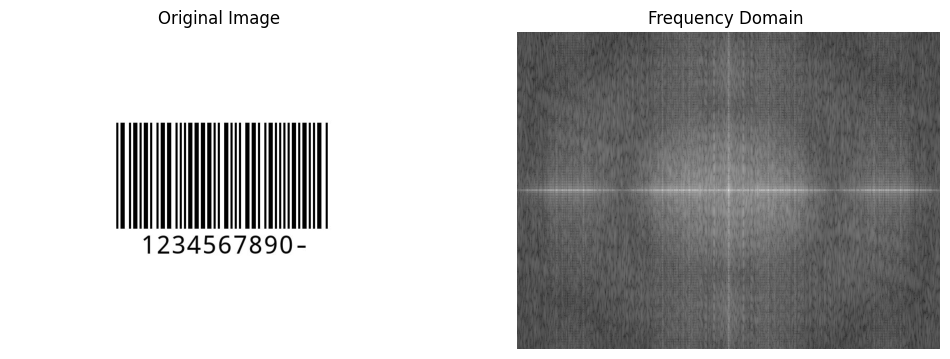

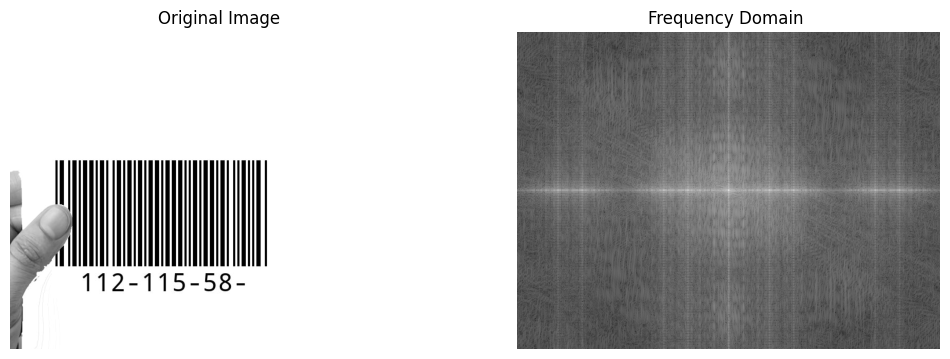

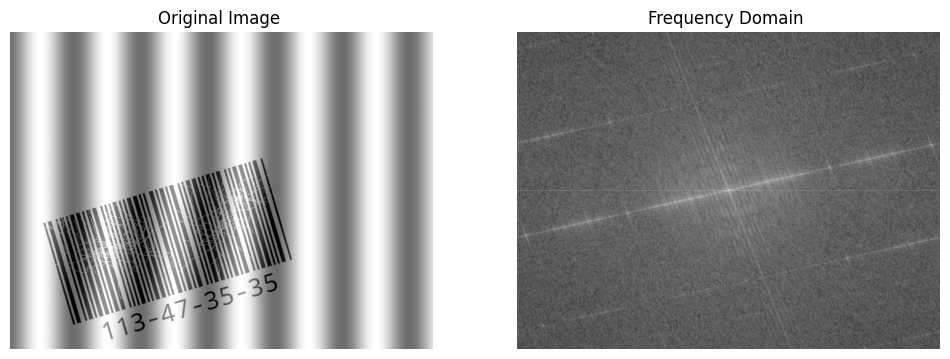

In [65]:
image=cv2.imread("01 - lol easy.jpg",cv2.IMREAD_GRAYSCALE)

image2=cv2.imread("11 - bayza 5ales di bsara7a.jpg",cv2.IMREAD_GRAYSCALE)

image3=cv2.imread("03 - eda ya3am ew3a soba3ak mathazarsh.jpg",cv2.IMREAD_GRAYSCALE)

show_frequency_domain(image)

show_frequency_domain(image3)


show_frequency_domain(image2)

crop and salt and pepper 

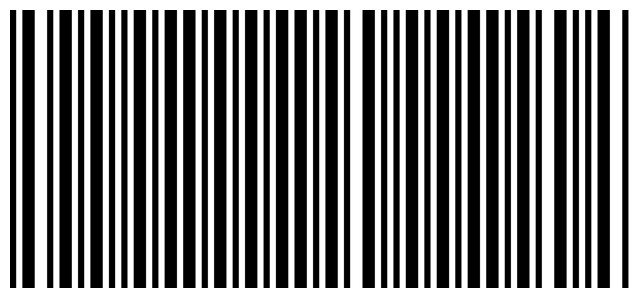

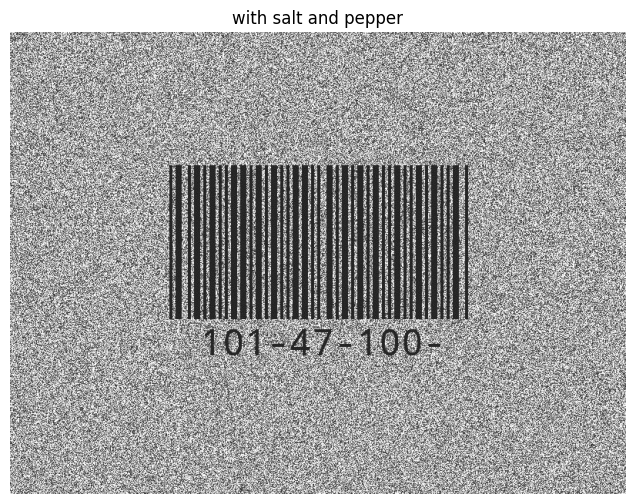

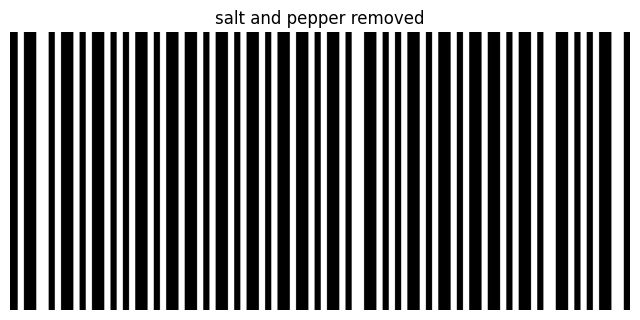

In [66]:
image = cv2.imread('02 - still easy.jpg', cv2.IMREAD_GRAYSCALE)
image=crop_image_contour_sorry_kiwi(image)

display_image(image)

image_salt=cv2.imread('07 - mal7 w felfel.jpg', cv2.IMREAD_GRAYSCALE) 

display_image(image_salt,'with salt and pepper')

if(detect_salt_pepper_noise(image_salt)):
    # we used closing because the number of salt and pepper was huge and median filter wont work, since the salt and pepper would still be at the center
    # the width of the closing kernel can be reduced if the bars were not clear
    new_image=perform_closing(image)
    display_image(new_image, 'salt and pepper removed')





periodic noise 


Top 5 most repeated angles:
Angle: 45.00 degrees, Count: 55
Angle: 163.00 degrees, Count: 53
Angle: 164.00 degrees, Count: 37
Angle: 58.00 degrees, Count: 27
Angle: 72.00 degrees, Count: 25
(True, 2)
(False, 0)


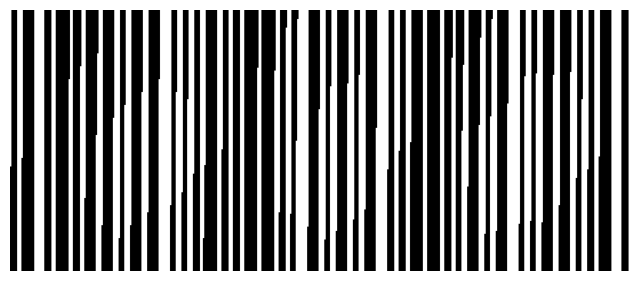

In [67]:
image=cv2.imread('11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)
rotated = rotate_img(image,find_angle(image))
image2=cv2.imread('01 - lol easy.jpg', cv2.IMREAD_GRAYSCALE)


print(detect_periodic_noise_lines(rotated))
print(detect_periodic_noise_lines(image2))

fixed_image=remove_periodic_noise(rotated)
fixed_image=crop_image_contour_sorry_kiwi(fixed_image)

fixed_image=threshold_image(fixed_image,find_threshold_value(fixed_image),255)
fixed_image= perform_opening(fixed_image)
display_image(fixed_image)


<h1>Blur Detection<h1>



The characteristic we found for detecting blur is the values we get from running a laplacian filter (2nd order derivative)
and analyzing the values.

The intuition behind this is that the 2nd order derivative gets the mesure of sharpness (quick changes)

In normal pictures (not blurred) the result should a wide range of values , both the high values of the strong edges and
the low values of the flat spaces

In blurred photos we wouldn't have that range of values

Soo in conclusion the variance of the result would be low.

So we can analyze the variance of the laplacian of our images and analyze what are the standard values of the barcodes variance

In [68]:
def variance_of_laplacian(image):
	return cv2.Laplacian(image, cv2.CV_64F).var()

def detectBlur(image):
    
    var=variance_of_laplacian(image)
    if var<1500:
        return True
    else :
        return False

In [69]:
picture_names = [
    "01 - lol easy.jpg",
    "02 - still easy.jpg",
    "03 - eda ya3am ew3a soba3ak mathazarsh.jpg",
    "04 - fen el nadara.jpg",
    "05 - meen taffa el nour!!!.jpg",
    "06 - meen fata7 el nour 333eenaaayy.jpg",
    "07 - mal7 w felfel.jpg",
    "08 - compresso espresso.jpg",
    "09 - e3del el soora ya3ammm.jpg",
    "10 - wen el kontraastttt.jpg",
    "11 - bayza 5ales di bsara7a.jpg"
]



for pic in picture_names:
    image=cv2.imread(pic,cv2.IMREAD_GRAYSCALE)

    var=variance_of_laplacian(image)

    print(var)

#intuition behind results

# first 3 pictures totally fine high variance values should be the standard

#4th low value compared expected as it is actually blurry

# 5th and 6th , it makes sense that they are very low values since they are very dark or very white so actually not a lot of variance here

#salt and pepper , very high variance ok

#compresso espresso low value compared to first 3 but not really low like the 4th which is logical since it is a bit blurry but not as much as the other one
#  picture 9 also it is a bittt blurry but not really so 2000 is expected
# kontraaaaast same issue as black or dark kinda good since kontraas and bluriness and brightness can be fixed by the thresholding
# 
# finallyyyy last one is a bit weird but we would detect periodic noise before checking the bluriness
# probably would work
 


#then we can threshold to get a better looking picture with our kinda smart thresholding

4669.435829166667
4631.7931
4413.379930912149
253.431
15.635929166666667
12.337404166666667
77916.15300921956
1354.5365875
2273.8769912549283
1.2291666666666667
853.7488479790106


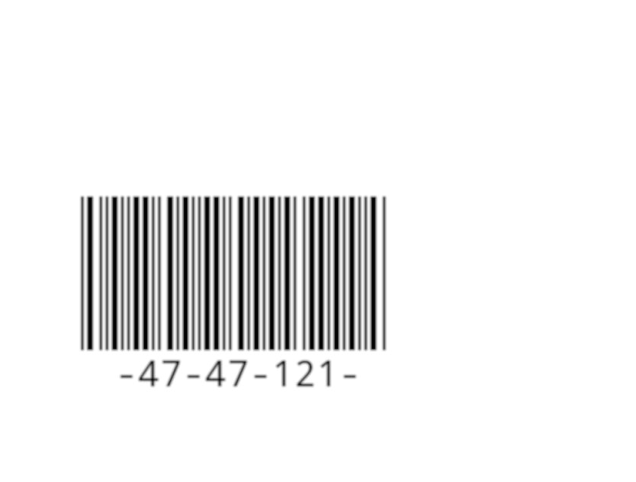

True


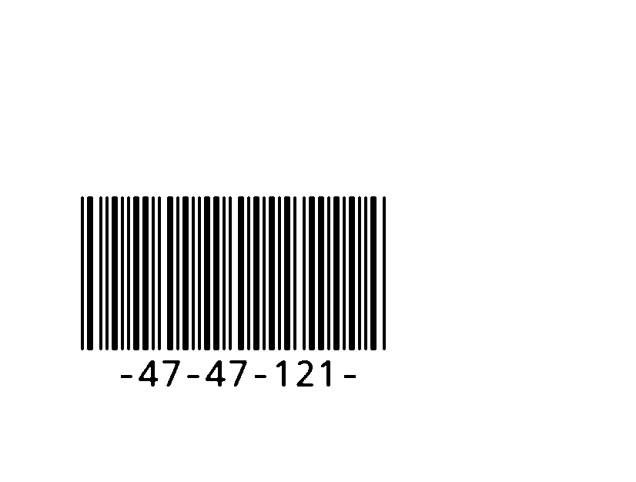

In [70]:
image_blurred=cv2.imread("04 - fen el nadara.jpg",cv2.IMREAD_GRAYSCALE)

display_image(image_blurred)

print(detectBlur(image_blurred))

threshold=find_threshold_value(image_blurred)

_,image_not_blurred_anymore=cv2.threshold(image_blurred,threshold,255,cv2.THRESH_BINARY)

display_image(image_not_blurred_anymore)


<h1>Rotation<h1>


To be able to rotate the barcodes and actually detect the angle of rotation it needs(maybe it doesn't need)

We detect the angles using hough lines, since when the image is hough-transformed we are detecting lines and angles

So we count the most dominant line angle in the find angle.

The results needed to be looked at for a while to check for patterns.

We found out that the image in need of rotation every time had 45 as its most common angle but this isn't the angle of rotation, the angle of rotation was actually the second most common.

For the images that don't need rotation they always had 0 as its most common angle which is a a logical result since we are counting the angles of the lines of the barcodes.


In [71]:
image_in_need_of_rotation=cv2.imread("09 - e3del el soora ya3ammm.jpg",cv2.IMREAD_GRAYSCALE)

angle1=find_angle(image_in_need_of_rotation)

another_image_in_need_of_rotation=cv2.imread("11 - bayza 5ales di bsara7a.jpg",cv2.IMREAD_GRAYSCALE)

angle2=find_angle(another_image_in_need_of_rotation)

image_not_in_need_of_rotation=cv2.imread("01 - lol easy.jpg",cv2.IMREAD_GRAYSCALE)

find_angle(image_not_in_need_of_rotation)


Top 5 most repeated angles:
Angle: 45.00 degrees, Count: 80
Angle: 152.00 degrees, Count: 78
Angle: 58.00 degrees, Count: 45
Angle: 65.00 degrees, Count: 42
Angle: 62.00 degrees, Count: 39

Top 5 most repeated angles:
Angle: 45.00 degrees, Count: 55
Angle: 163.00 degrees, Count: 53
Angle: 164.00 degrees, Count: 37
Angle: 58.00 degrees, Count: 27
Angle: 72.00 degrees, Count: 25

Top 5 most repeated angles:
Angle: 0.00 degrees, Count: 78
Angle: 45.00 degrees, Count: 4
Angle: 90.00 degrees, Count: 3
Angle: 58.00 degrees, Count: 2
Angle: 122.00 degrees, Count: 2


0.0

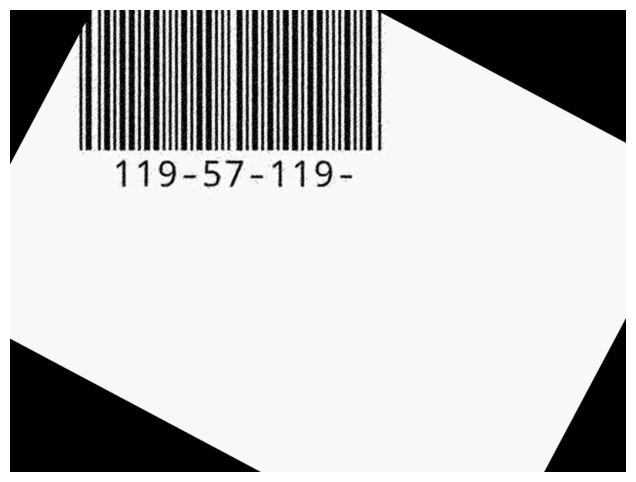

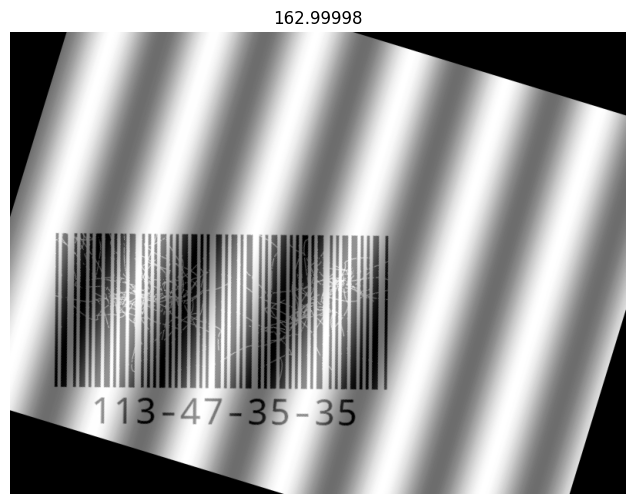

In [72]:
image_not_in_need_of_rotation_anymore=rotate_img(image_in_need_of_rotation,angle1)

display_image(image_not_in_need_of_rotation_anymore)


another_image_not_in_need_of_rotation_anymore=rotate_img(another_image_in_need_of_rotation,angle2)

display_image(another_image_not_in_need_of_rotation_anymore,angle2)

#since the angle of the image not in need of rotation is 0 so in a pipeline setting we find out that this isn't in need of rotation



Notice the corners but we got that covered

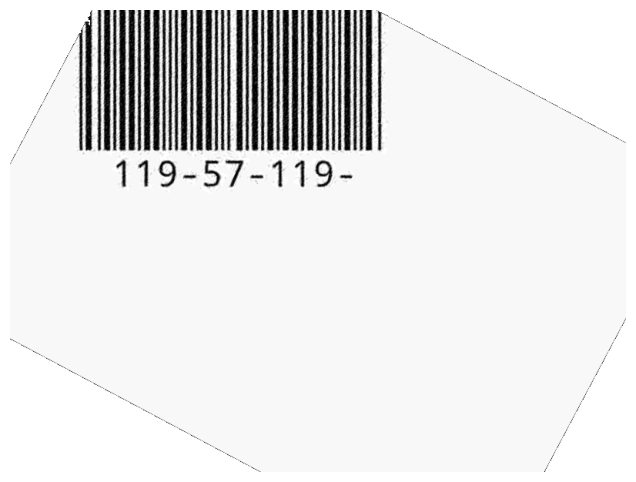

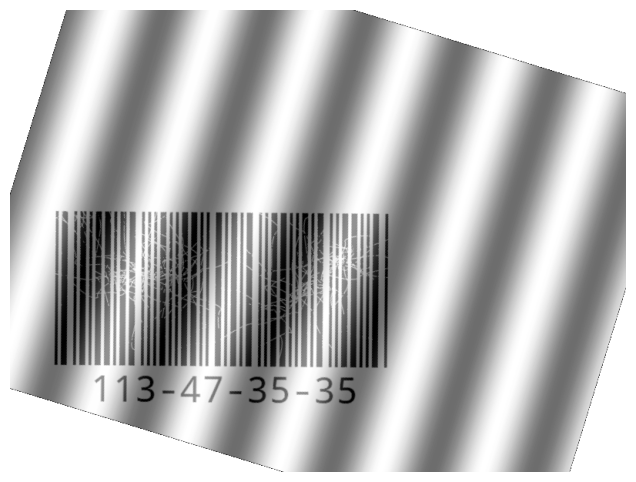

In [73]:
image_not_in_need_of_rotation_anymore=fill_corners(image_not_in_need_of_rotation_anymore)

display_image(image_not_in_need_of_rotation_anymore)

another_image_not_in_need_of_rotation_anymore=fill_corners(another_image_not_in_need_of_rotation_anymore)

display_image(another_image_not_in_need_of_rotation_anymore)

<h1>Finding Threshold value to be used <h1>

We needed to analyze histograms to be able to detect dark , bright and contrast issues

And to be able to fix them we thought that since the bins in these types of pictures would be concentrated in one part(low,middle or high) that would fix the image

We used that approach in this function.

This is also a really general way of finding kind of optimal thresholding value so it would work to threshold other images like blurred




In [74]:


def find_threshold_value(img_gray):
    hist_counts, bin_edges = np.histogram(img_gray.ravel(), bins=64, range=(0, 256))
    total_pixels = img_gray.size
    
    # Calculate the number of pixels in the dark region (0 to 127)
    dark_pixels = np.sum(hist_counts[:32])  

    # Calculate the number of pixels in the bright region (128 to 255)
    bright_pixels = np.sum(hist_counts[32:])  

    # get the percentage of dark and bright pixels
    dark_percentage = dark_pixels / total_pixels
    bright_percentage = bright_pixels / total_pixels

    # Get indices of the top 5 bins with the highest counts, excluding zero bins
    non_zero_indices = np.where(hist_counts > 0)[0] 
    top_5_indices = np.argsort(hist_counts[non_zero_indices])[-5:][::-1]  
    top_5_bins = [bin_edges[non_zero_indices[i]] for i in top_5_indices]
    # print(top_5_bins)

    # tried weighted average first but this is better apparently and kinda makes sense
    top_5_values = [np.mean([bin_edges[non_zero_indices[i]], bin_edges[non_zero_indices[i] + 1]]) for i in top_5_indices]

 
    average = np.mean(top_5_values)

    contrast_bin_range = (120, 136)  
    contrast_bins = np.sum(hist_counts[np.logical_and(bin_edges[:-1] >= contrast_bin_range[0], bin_edges[:-1] < contrast_bin_range[1])])
    contrast_percentage = contrast_bins / total_pixels


    #The values for the every one 

    if contrast_percentage > 0.6:  # threshold for contrast concentration
        return math.floor(average)

    if dark_percentage > 0.8:
         return math.floor(average)  # threshold for dark-biased images
    elif bright_percentage > 0.95:  #makes sense that this threshold needs to be higher than dark since the picture by default would be biased to white (background)
      
         return math.floor(average)  # threshold for bright-biased images
    else:
         return math.floor(average)

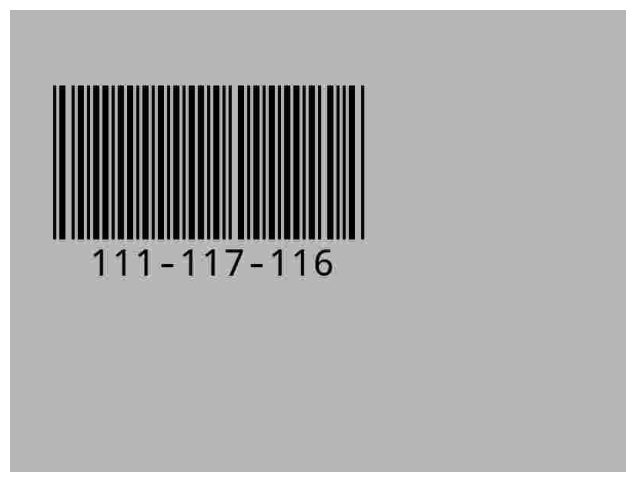

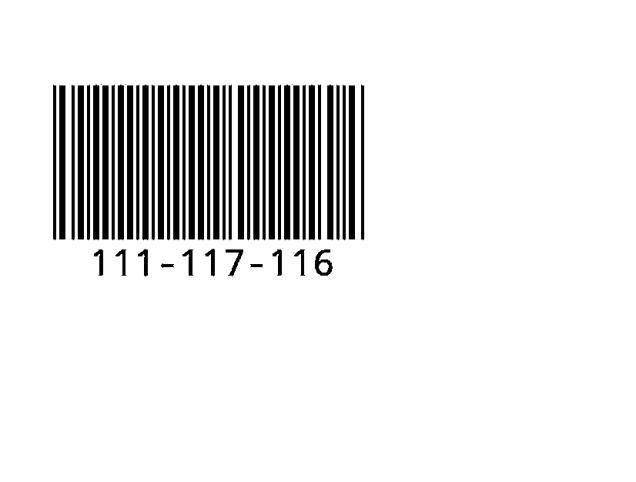

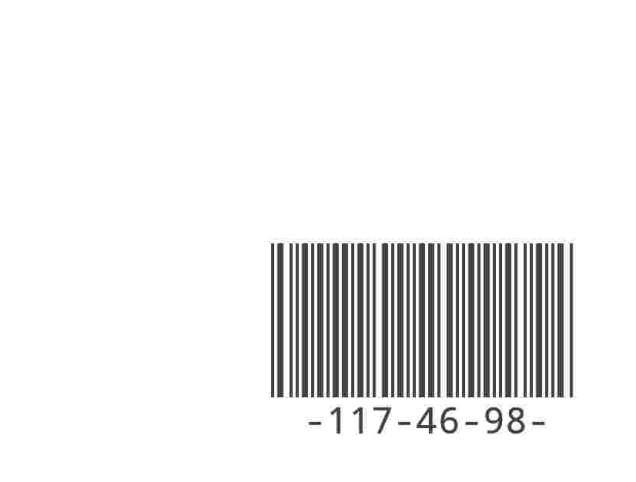

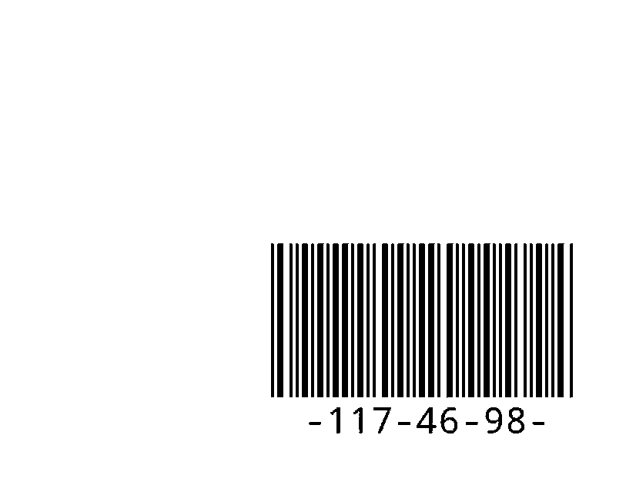

In [75]:
image_dark=cv2.imread("05 - meen taffa el nour!!!.jpg",cv2.IMREAD_GRAYSCALE)


display_image(image_dark)

threshold=find_threshold_value(image_dark)


image_dark_fixed=threshold_image(image_dark,threshold,255)


display_image(image_dark_fixed)


image_bright=cv2.imread("06 - meen fata7 el nour 333eenaaayy.jpg",cv2.IMREAD_GRAYSCALE)

display_image(image_bright)

threshold=find_threshold_value(image_bright)

image_bright_fixed=threshold_image(image_bright,threshold,255)

display_image(image_bright_fixed)






<h1>Pipeline</h1>

we divided our pipeline into 5 phases, each phase will try to tackle some problems, if the image was decoded it would be removed and stored into a separate list, where the image which was not decoded will be passed to another list who will go through the other phases in the pipeline

In [76]:
picture_names = [
    "01 - lol easy.jpg",
    "02 - still easy.jpg",
    "03 - eda ya3am ew3a soba3ak mathazarsh.jpg",
    "04 - fen el nadara.jpg",
    "05 - meen taffa el nour!!!.jpg",
    "06 - meen fata7 el nour 333eenaaayy.jpg",
    "07 - mal7 w felfel.jpg",
    "08 - compresso espresso.jpg",
    "09 - e3del el soora ya3ammm.jpg",
    "10 - wen el kontraastttt.jpg",
    "11 - bayza 5ales di bsara7a.jpg"
]

ready_for_decoding = []
not_ready = []
    

<h3>Phase 0</h3>
<br>We simply check if the given image can be decoded when we crop it which means that the image is in no need for processing 
If they can be decoded then they can be put into our ready to be decoded array and if they can't then we append them to the not ready list to be given to the next stage of the pipeline


In [77]:
def phase0():  # if only cropping is needed to fix
    for pic in picture_names:
        image = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
        org_image = image.copy()
        try:
            image = crop_image_contour_sorry_kiwi(image)
        except:
            print("can't be cropped")
        if decode_barcode(image):
            ready_for_decoding.append((image, pic))  # Store image with its name
        else:
            not_ready.append((org_image, pic))  # Store image with its name

<h3>Phase 1</h3>
We check if the image is in need of salt and pepper processing with our detection function and then we fix it by preforming closing with a kernel of the same height and width of the barcode

Then we try to crop and decode, if it gets decoded then its only issue was salt and pepper and it can be added to the ready to be decoded array

If it wasn't decoded then it has another problem other than the salt and pepper so we remove the original image from the not ready and re-add it after the salt and pepper is fixed and we go to the other phase to see what other problems it may have 


In [78]:


def phase2():  # Searching for salt and pepper
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:
        org_image = image.copy()
        if detect_salt_pepper_noise(image):
            image = perform_closing(image)
            cropped_image = crop_image_contour_sorry_kiwi(image)


            if decode_barcode(cropped_image):
                not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
                ready_for_decoding.append((cropped_image, pic))  # Store image with its name
            else:
                not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
                not_ready.append((image, pic))  # Store image with its name






<h3>Phase 2</h3>
this phase is set for detecting lighting problems 

We get the rest of the images from the not ready list and then we try to detect brightness-contrast-bluriness problems since they can all be fixed by our thresholding function

Then as usual we try to crop and decode 

if it works it gets added to the ready list

if it doesn't we remove the old one and readd it after fixing brightness-contrast-bluriness problems with out trusty thresholding function

In [79]:
def phase1():  # fix lighting problems
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:
        org_image = image.copy()
        hist_counts, bin_edges, total_pixels = compute_histogram(image)
        if (detect_bright(hist_counts, bin_edges, total_pixels) or
            detect_dark(hist_counts, bin_edges, total_pixels) or
            detect_contrast(hist_counts, bin_edges, total_pixels)) or detectBlur(image):
            image = threshold_image(image, find_threshold_value(image), 255)
        cropped_img = crop_image_contour_sorry_kiwi(image)

        if decode_barcode(cropped_img):
            not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
            ready_for_decoding.append((cropped_img, pic))  # Store image with its name
        elif(not detect_periodic_noise_lines(org_image)):
             not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
             not_ready.append((image, pic))


<h3>Phase 3</h3>
if the image is rotated

simply we check for angle of rotation with our find angle function, if the angle is 0 then no need for anything to be done and onto the next phase nothing gets changed in the arrays

if the angle is non zero then we rotate and try to decode

like the other phases we check if it can be decoded then done if not then it is pushed to the other phases

In [80]:

def phase3():  # angles
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:  # Iterate over a copy of the list to avoid modifying it during iteration
        org_image = image.copy()
        if find_angle(image) != 0:
            angle = find_angle(image)
            rotated_img = rotate_img(image, angle)
            rotated_img = fill_corners(rotated_img)
            threshold=threshold_image(rotated_img,find_threshold_value(rotated_img),255)

        cropped_img = crop_image_contour_sorry_kiwi(threshold)

        if decode_barcode(cropped_img):
            not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
            ready_for_decoding.append((cropped_img, pic))  # Store image with its name
        else:
            not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
            not_ready.append((rotated_img, pic))  # Store image with its name


<h3>Phase 4</h3>
The last problem we are checking is the presence of periodic noise

We try to detect with the detection function if it gets detected then we fix it with remove noise function and threshold for better results with our function 

then we crop and decode the final image


In [81]:
def phase4():  # angles
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:  # Iterate over a copy of the list to avoid modifying it during iteration
        org_image = image.copy()
        if detect_periodic_noise_lines(image,offset=2):
            image=remove_periodic_noise(image)
            image=crop_image_contour_sorry_kiwi(image)

            image=threshold_image(image,find_threshold_value(image),255)
            image= perform_opening(image)
            if decode_barcode(image):
                not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
                ready_for_decoding.append((image, pic))  # Store image with its nam

Running all phases

In [82]:
ready_for_decoding = []
not_ready = []

phase0()
phase1()
phase2()
phase3()
phase4()

11110000111111110000000011110000111111110000111100001111111100001111000000001111000011111111000011111111000000001111000011110000111100001111111100001111111100001111111100001111111100001111000011110000000011111111000011110000111100001111000000001111111100001111111100001111000000001111000011111111000011110000111100001111000011110000111111110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']
11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000000011111111000011110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111000000001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '

AS a final processing step before displaying the images, we will run mask_freq function, which creates a mask with a very low bandwidth (1) in the frequency domain, to remove any sinc function that are not horizontal in the center, based on the idea that there is no change in intensities vertically, and there should only be a horizontal sinc in the freq domain
this steps removes objects and fixes bars that were distored as we removed any noise that could be there

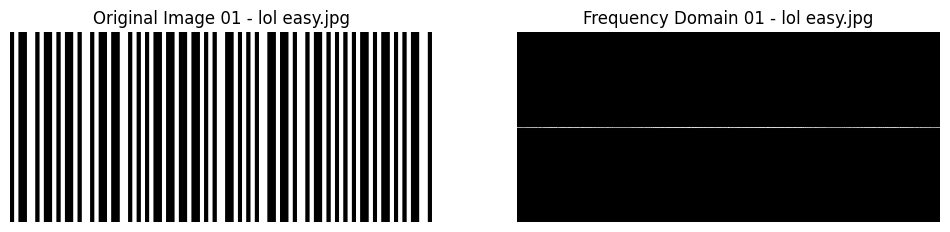

11110000111111110000000011110000111111110000111100001111111100001111000000001111000011111111000011111111000000001111000011110000111100001111111100001111111100001111111100001111111100001111000011110000000011111111000011110000111100001111000000001111111100001111111100001111000000001111000011111111000011110000111100001111000011110000111111110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']


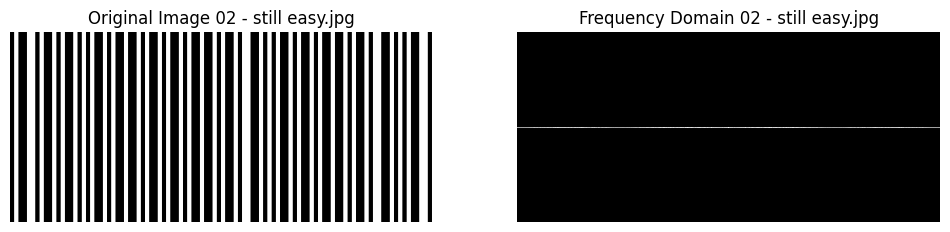

11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000000011111111000011110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111000000001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']


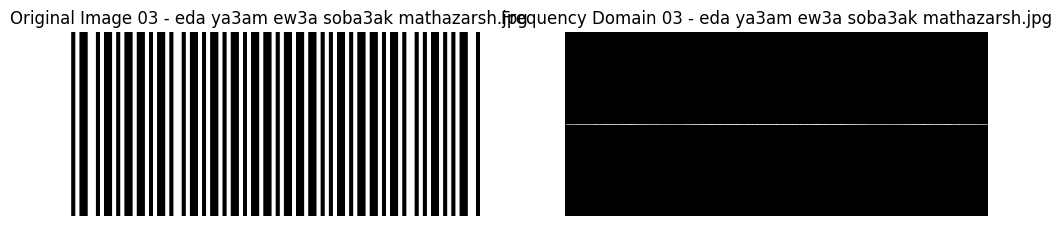

11110000111111110000000011110000111111110000111100001111111100001111111100001111000011111111000011110000000011110000111111110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111111100001111111100001111000011110000111111110000111100001111111100001111111100001111000011111111000011110000000011110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start']


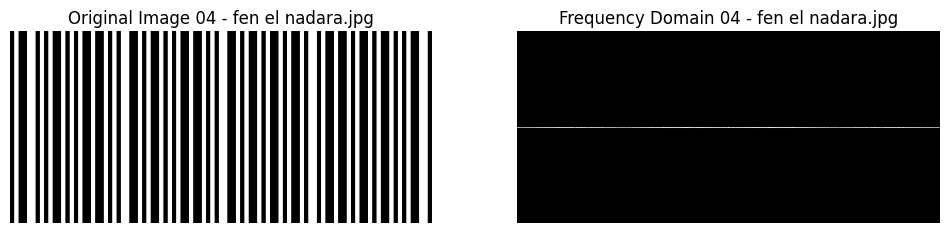

1111000011111111000000001111000011110000111111110000111100001111000011111111000011111111000011110000111100000000111111110000111100001111111100001111000011110000111111110000111111110000111100001111000000001111111100001111000011111111000011110000111111110000111100001111111100001111000000001111000011111111000011111111000011110000111111110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start']


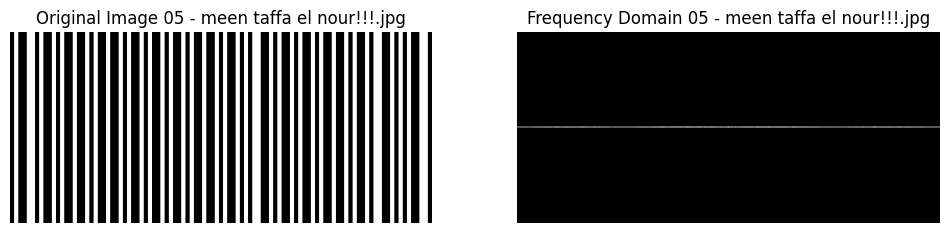

111100001111111100000000111100001111111100001111000011111111000011111111000011110000111111110000111111110000111100001111111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111100000000111111110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111000000001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']


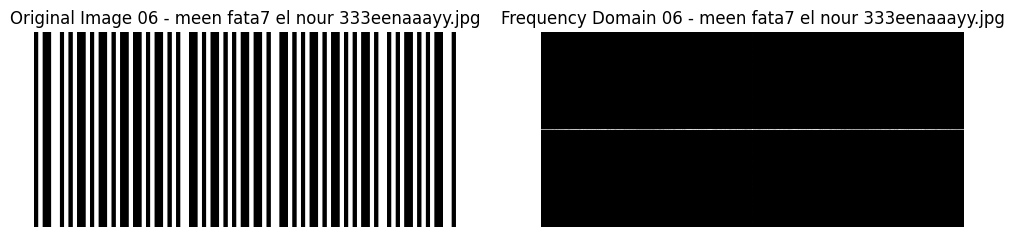

111100001111111100000000111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111100000000111111110000111100001111111100001111000011110000111111110000111111110000111100000000111111110000111100001111000011111111000011110000111111110000111100001111000011111111000011110000000011110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']


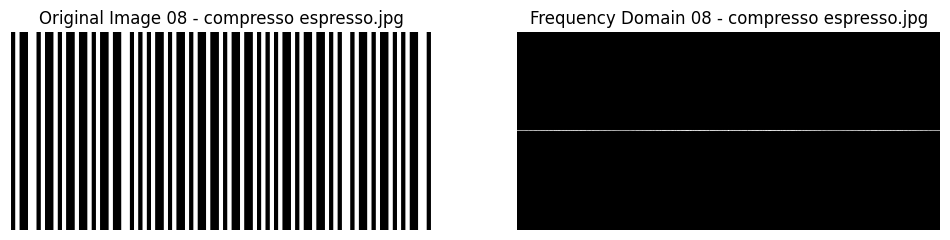

11110000111111110000000011110000111111110000111100001111111100001111111100001111000011111111000011111111000000001111000011110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111111100001111000011110000111100001111111100001111000011111111000011111111000011110000111100000000111100001111111100001111000011111111000011110000111100001111111100000000111100
Decoded barcode value: ['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start']


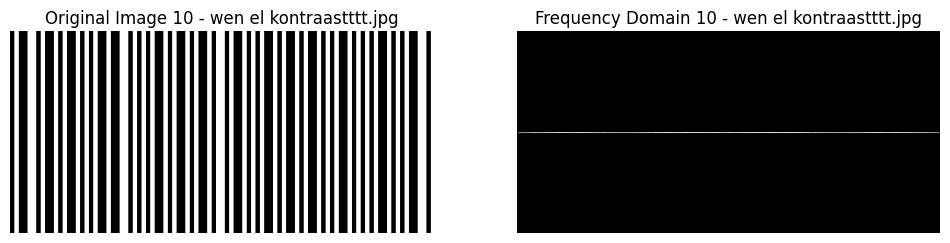

11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111111110000000011110000111100001111000011111111000011110000111111110000111100001111111100001111000000001111000011111111000011110000111100001111111100001111000011111111000011110000111111110000111100001111000011111111000011110000111100001111000011111111000011110000111100001111111100000000111100
Decoded barcode value: ['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']


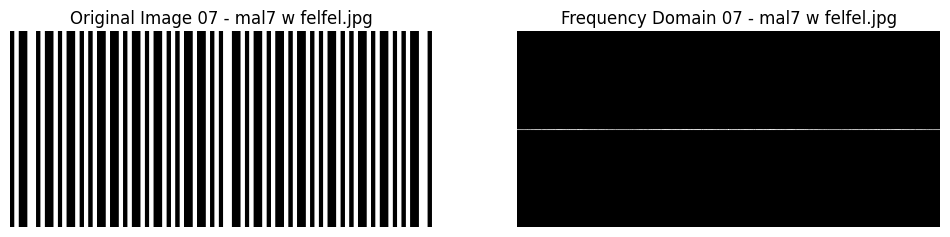

11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111111110000111100001111111100001111000011111111000011110000111100001111111100001111111100001111000011110000000011111111000011110000111111110000111100001111111100001111000011111111000011110000111100001111111100001111000011110000111111110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start']


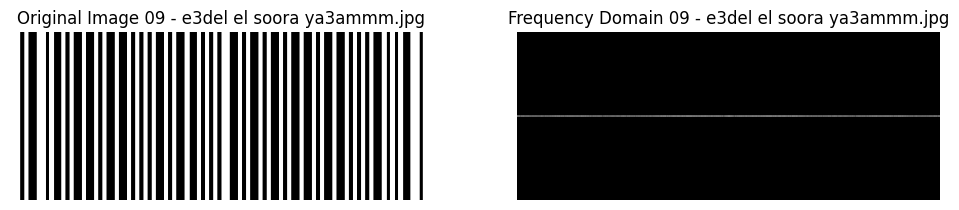

111100001111111100000000011100000111111100001111000011111111000011111111000011110000111111110000111111110000111100001111000011110000111111110000111100001111111100000111111100001111000011110000111100000000111111110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111111100001111000011110000111100001111111100000111000001110000011111110000000001110000000000
Decoded barcode value: ['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start']


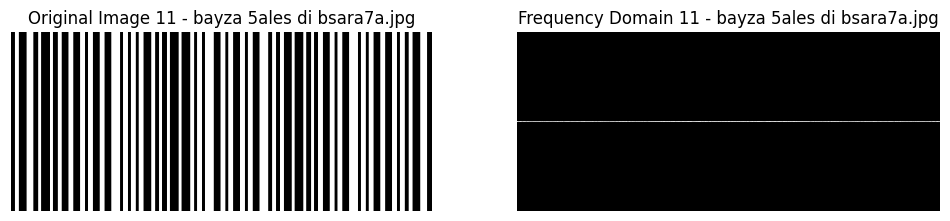

1111000011111111000000011111000111111111000111110000111111100000111111100000111000001111111000001111111000000000111000001110000011100000111111110000111100011111000111111111000111111111000011100000111000000000111111100000111000001111111000001110000011111110000000001111000011110000111111110001111111110001111100011110000011111110000011100000111111100000000011100000111000001111111000001111111000001110000011110000111111110000000111110
Decoded barcode value: ['Stop/Start', '1', '1', '3', '-', '4', '7', '-', '3', '5', '-', '3', '5', 'Stop/Start']


In [83]:

for image, pic in ready_for_decoding:
    if(not is_horizontal_sinc(image)):
        image=mask_freq(image,True,False)
        
    show_frequency_domain(image,pic)
    decode_barcode(image)
